<a href="https://colab.research.google.com/github/Nyeonging/Camera_Pose_M/blob/main/depthmodel_team5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
import numpy as np
import math

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋 클래스 정의
class PoseDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.dataframe.iloc[idx, 1:].values.astype('float32')
        labels = torch.tensor(labels, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels

# 데이터 증강 및 변환 설정
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                # 이미지 크기를 256x256으로 조정
    transforms.RandomHorizontalFlip(),            # 랜덤으로 이미지 수평 반전
    transforms.RandomRotation(10),                # 랜덤으로 이미지 10도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 이미지 색상 조정
    transforms.ToTensor(),                        # 이미지를 텐서로 변환
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),                # 이미지 크기를 256x256으로 조정
    transforms.ToTensor(),                        # 이미지를 텐서로 변환
])

# CSV 파일 로드
csv_file_path = "C:/JES/RC/rc0610.csv"
image_folder = "C:/JES/RC/vid/Frames0605/"

data = pd.read_csv(csv_file_path)

# 각도 값을 라디안으로 변환
data.iloc[:, 4:7] = np.deg2rad(data.iloc[:, 4:7])  # 추가된 부분

# 데이터셋 분할
train_data = data.sample(frac=0.8, random_state=42)  # 80%를 학습 데이터로 사용
val_test_data = data.drop(train_data.index)
val_data = val_test_data.sample(frac=0.5, random_state=42)  # 나머지 20%를 검증 및 테스트 데이터로 나눔
test_data = val_test_data.drop(val_data.index)

# 데이터셋 및 데이터 로더
train_dataset = PoseDataset(dataframe=train_data, image_folder=image_folder, transform=train_transform)
val_dataset = PoseDataset(dataframe=val_data, image_folder=image_folder, transform=test_transform)
test_dataset = PoseDataset(dataframe=test_data, image_folder=image_folder, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# MiDaS 모델 불러오기
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
midas.to(device)
midas.eval()
midas_transform = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform

# 모델 정의
class CameraPoseEstimationModel(nn.Module):
    def __init__(self):
        super(CameraPoseEstimationModel, self).__init__()
        self.resnet_rgb = models.resnet50(pretrained=True)
        self.resnet_depth = models.resnet50(pretrained=True)

        # ResNet의 fc layer 제거
        self.resnet_rgb.fc = nn.Identity()
        self.resnet_depth.fc = nn.Identity()

        # 새로운 fc layer 정의
        self.fc = nn.Linear(2048 * 2, 6)  # 2048은 ResNet 출력 차원, depth와 원본 이미지를 결합하므로 2배

    def forward(self, rgb):
        depth_maps = []
        for i in range(rgb.size(0)):
            rgb_pil = transforms.ToPILImage()(rgb[i].cpu())  # 개별 이미지를 PIL로 변환
            rgb_np = np.array(rgb_pil) / 255.0  # PIL 이미지를 numpy 배열로 변환하고 정규화
            input_batch = midas_transform(rgb_np).to(device)  # numpy 배열을 midas_transform에 전달
            with torch.no_grad():
                prediction = midas(input_batch)
                depth_map = torch.nn.functional.interpolate(
                    prediction.unsqueeze(1),
                    size=(256, 256),
                    mode="bicubic",
                    align_corners=False,
                ).squeeze()
            # depth map 수정 부분 추가
            min_value = depth_map.min()
            depth_map = depth_map - (min_value - 0.1)
            depth_map = 1.0 / depth_map
            depth_maps.append(depth_map.unsqueeze(0))  # depth map 리스트에 추가

        depth_maps = torch.stack(depth_maps)  # depth maps를 스택하여 배치로 변환
        depth_maps = depth_maps.repeat(1, 3, 1, 1)  # depth map을 3채널로 복제
        rgb = rgb.to(device)
        depth_maps = depth_maps.to(device)

        x_rgb = self.resnet_rgb(rgb)
        x_depth = self.resnet_depth(depth_maps)
        x = torch.cat((x_rgb, x_depth), dim=1)
        x = self.fc(x)

        pos = x[:, :3]
        rot = x[:, 3:]

        return pos, rot

# Custom Loss Function 정의
class CustomMinLoss(nn.Module):
    def __init__(self):
        super(CustomMinLoss, self).__init__()

    def forward(self, output, target):
        diff = (output - target)
        diff = torch.where(diff > torch.tensor(math.pi), diff - 2 * math.pi, diff)
        diff = torch.where(diff < -torch.tensor(math.pi), diff + 2 * math.pi, diff)
        diff = torch.abs(diff)
        return torch.mean(diff)

# Mixed Loss Function 정의 (MSE + CustomMinLoss 가중 합)
class MixedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(MixedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.custom_min_loss = CustomMinLoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, output, target):
        mse_loss_value = self.mse_loss(output, target)
        custom_min_loss_value = self.custom_min_loss(output, target)
        return self.alpha * mse_loss_value + self.beta * custom_min_loss_value

# 모델 및 학습 설정
model = CameraPoseEstimationModel().to(device)
mixed_loss = MixedLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 학습 및 평가
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for rgb_images, labels in train_loader:
        rgb_images, labels = rgb_images.to(device), labels.to(device)
        optimizer.zero_grad()
        pos, rot = model(rgb_images)
        outputs = torch.cat((pos, rot), dim=1)
        loss = mixed_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * rgb_images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for rgb_images, labels in val_loader:
            rgb_images, labels = rgb_images.to(device), labels.to(device)
            pos, rot = model(rgb_images)
            outputs = torch.cat((pos, rot), dim=1)
            loss = mixed_loss(outputs, labels)
            val_loss += loss.item() * rgb_images.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

    # Learning rate scheduler step
    scheduler.step(val_loss)


Using cache found in C:\Users\seoze/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\seoze/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\seoze/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\seoze\anaconda3\envs\spike\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\seoze\anaconda3\envs\spike\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Loss: 8.9394
Validation Loss: 10.4415
Epoch 2/100, Loss: 3.5803
Validation Loss: 3.1915
Epoch 3/100, Loss: 3.0963
Validation Loss: 1.8517
Epoch 4/100, Loss: 2.7636
Validation Loss: 2.7410
Epoch 5/100, Loss: 2.7823
Validation Loss: 2.6945
Epoch 6/100, Loss: 2.4793
Validation Loss: 5.4943
Epoch 7/100, Loss: 2.6664
Validation Loss: 1.9419
Epoch 8/100, Loss: 1.7687
Validation Loss: 0.9578
Epoch 9/100, Loss: 1.5052
Validation Loss: 1.0774
Epoch 10/100, Loss: 1.7688
Validation Loss: 1.3348
Epoch 11/100, Loss: 1.5085
Validation Loss: 1.1309
Epoch 12/100, Loss: 1.4634
Validation Loss: 1.9219
Epoch 13/100, Loss: 1.6800
Validation Loss: 0.8235
Epoch 14/100, Loss: 1.1103
Validation Loss: 0.7378
Epoch 15/100, Loss: 1.0396
Validation Loss: 0.8477
Epoch 16/100, Loss: 1.0474
Validation Loss: 0.6218
Epoch 17/100, Loss: 0.9432
Validation Loss: 0.6755
Epoch 18/100, Loss: 1.0140
Validation Loss: 0.6137
Epoch 19/100, Loss: 0.9014
Validation Loss: 0.6646
Epoch 20/100, Loss: 1.3443
Validation L

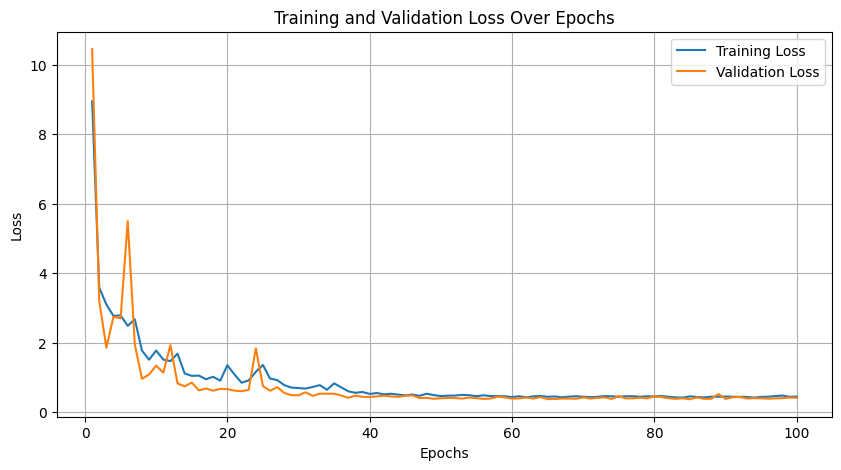

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 101))

# Loss and Validation Loss values
train_loss = [8.9394, 3.5803, 3.0963, 2.7636, 2.7823, 2.4793, 2.6664, 1.7687, 1.5052, 1.7688, 1.5085, 1.4634, 1.6800, 1.1103, 1.0396, 1.0474, 0.9432, 1.0140, 0.9014, 1.3443, 1.0807, 0.8426, 0.9090, 1.1539, 1.3541, 0.9627, 0.9184, 0.7736, 0.7022, 0.6897, 0.6735, 0.7212, 0.7730, 0.6384, 0.8246, 0.7098, 0.5945, 0.5516, 0.5759, 0.5197, 0.5454, 0.5090, 0.5247, 0.5000, 0.4770, 0.5014, 0.4656, 0.5254, 0.4866, 0.4587, 0.4708, 0.4732, 0.4933, 0.4823, 0.4545, 0.4813, 0.4573, 0.4567, 0.4531, 0.4291, 0.4517, 0.4246, 0.4506, 0.4615, 0.4380, 0.4473, 0.4233, 0.4424, 0.4524, 0.4398, 0.4264, 0.4370, 0.4558, 0.4518, 0.4358, 0.4533, 0.4531, 0.4396, 0.4519, 0.4460, 0.4606, 0.4360, 0.4192, 0.4129, 0.4503, 0.4306, 0.4199, 0.4391, 0.4388, 0.4427, 0.4380, 0.4360, 0.4342, 0.4135, 0.4339, 0.4398, 0.4573, 0.4737, 0.4366, 0.4431]
val_loss = [10.4415, 3.1915, 1.8517, 2.7410, 2.6945, 5.4943, 1.9419, 0.9578, 1.0774, 1.3348, 1.1309, 1.9219, 0.8235, 0.7378, 0.8477, 0.6218, 0.6755, 0.6137, 0.6646, 0.6593, 0.6154, 0.5975, 0.6374, 1.8325, 0.7431, 0.6103, 0.7157, 0.5487, 0.4834, 0.4808, 0.5665, 0.4638, 0.5272, 0.5260, 0.5248, 0.4743, 0.4072, 0.4718, 0.4352, 0.4324, 0.4476, 0.4687, 0.4477, 0.4339, 0.4652, 0.4778, 0.4010, 0.4065, 0.3803, 0.3949, 0.4059, 0.4021, 0.3851, 0.4154, 0.3985, 0.3768, 0.3861, 0.4424, 0.4187, 0.3846, 0.3904, 0.4187, 0.3871, 0.4279, 0.3718, 0.3732, 0.3867, 0.3866, 0.3805, 0.4216, 0.3847, 0.4065, 0.4206, 0.3757, 0.4599, 0.3886, 0.3932, 0.4133, 0.3924, 0.4534, 0.4321, 0.3952, 0.3787, 0.3930, 0.3675, 0.4202, 0.3780, 0.3799, 0.5143, 0.3783, 0.4239, 0.4322, 0.3885, 0.3985, 0.3930, 0.3833, 0.3922, 0.3987, 0.4173, 0.4079]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
torch.save(model, 'entire_model.pth')

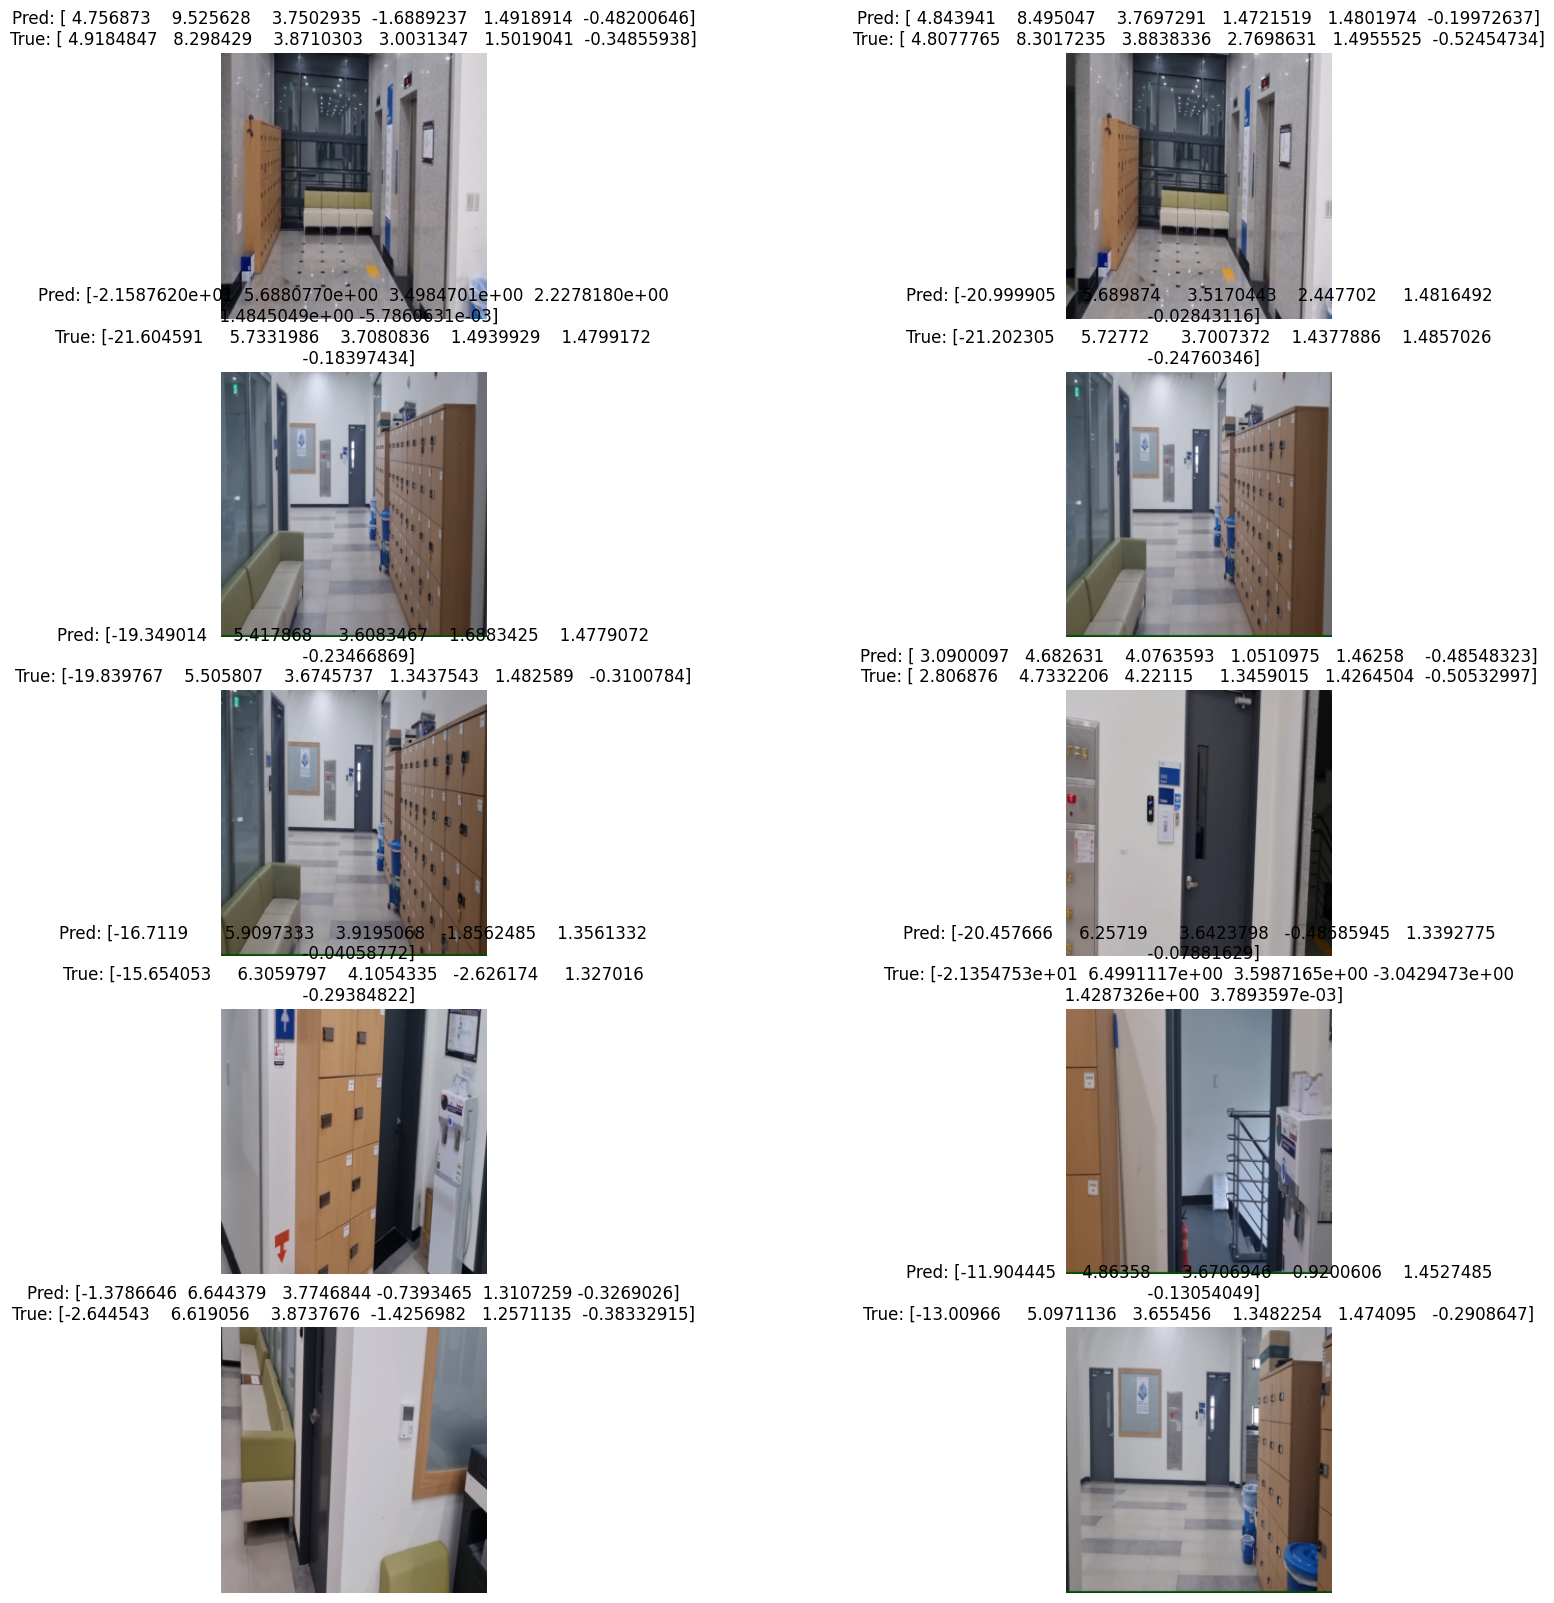

In [ ]:
import matplotlib.pyplot as plt

# 테스트 이미지에서 10개 가져와서 예측값, 실제값, 이미지를 시각화
def visualize_predictions(test_loader, model, device, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for i, (rgb_images, labels) in enumerate(test_loader):
            rgb_images = rgb_images.to(device)
            pos, rot = model(rgb_images)
            outputs = torch.cat((pos, rot), dim=1)

            for j in range(rgb_images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {outputs[j].cpu().numpy()}\nTrue: {labels[j].cpu().numpy()}')
                plt.imshow(rgb_images[j].cpu().permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=True)
                    return

visualize_predictions(test_loader, model, device, num_images=10)


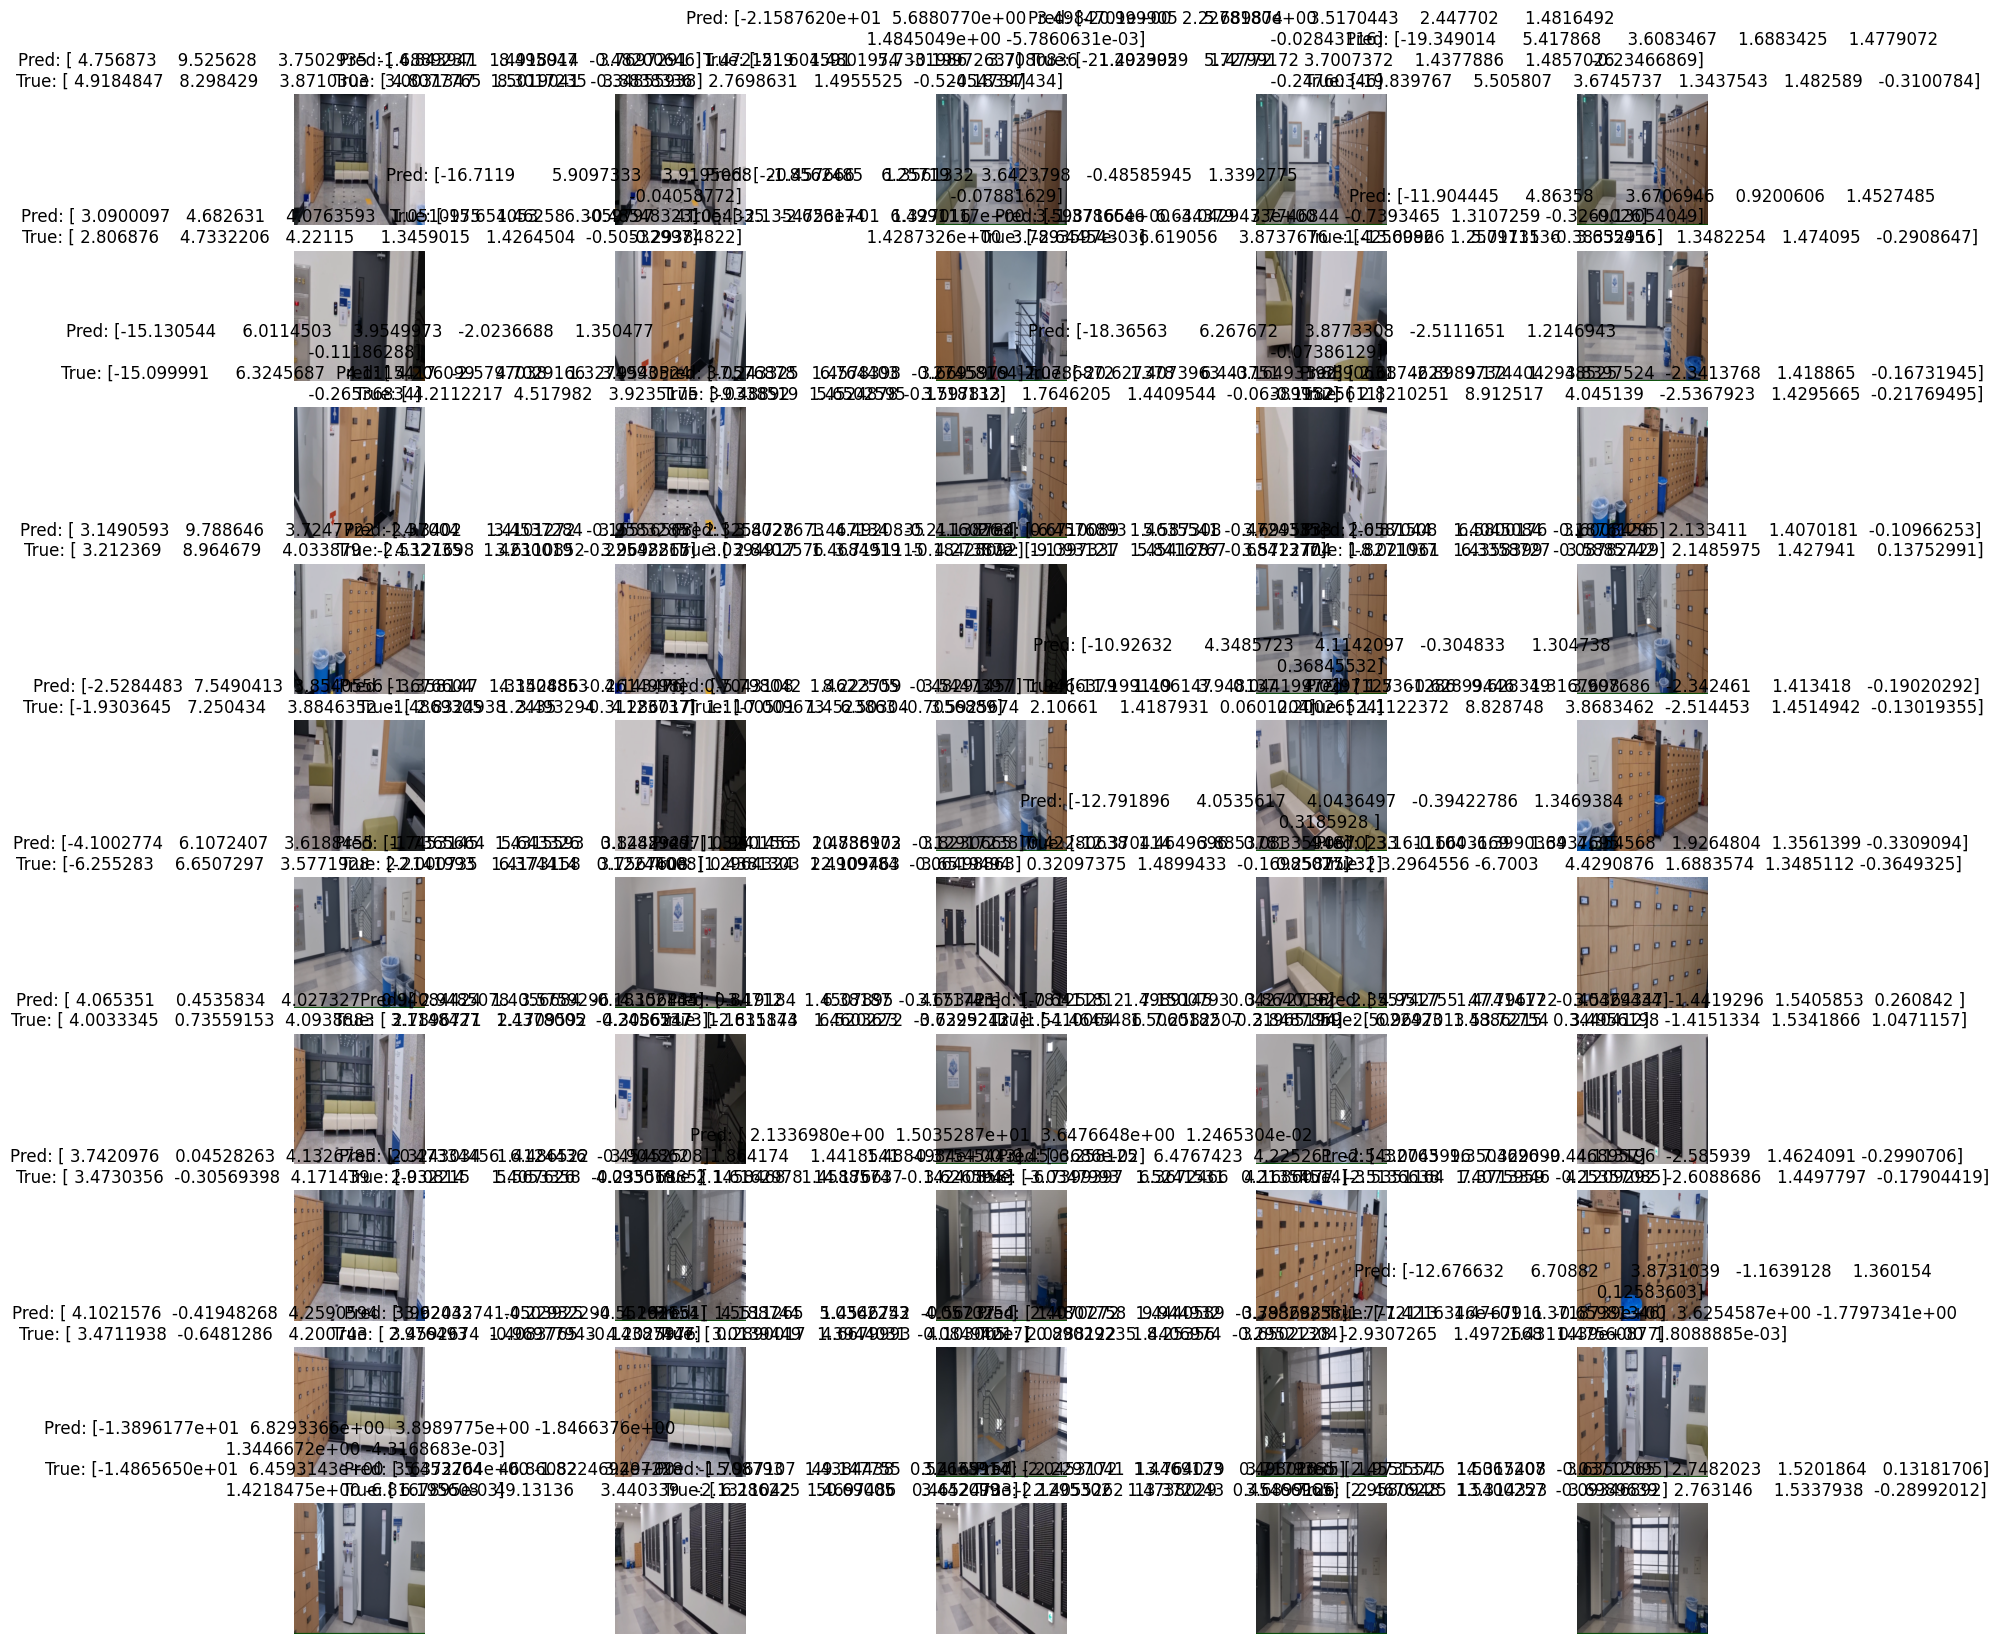

In [ ]:
import torch
import csv
import matplotlib.pyplot as plt

# 테스트 이미지에서 50개 가져와서 예측값, 실제값, 이미지를 시각화 및 CSV 저장
def visualize_predictions(test_loader, model, device, num_images=50, save_csv=True):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 20))

    # CSV 파일을 쓰기 모드로 열기
    if save_csv:
        pred_csv = open('predictions.csv', 'w', newline='')
        true_csv = open('truths.csv', 'w', newline='')

        pred_writer = csv.writer(pred_csv)
        true_writer = csv.writer(true_csv)

        # CSV 파일 헤더 작성
        pred_writer.writerow(['ImageName', 'Pred_X', 'Pred_Y', 'Pred_Z', 'Pred_Heading', 'Pred_Pitch', 'Pred_Yaw'])
        true_writer.writerow(['ImageName', 'True_X', 'True_Y', 'True_Z', 'True_Heading', 'True_Pitch', 'True_Yaw'])

    with torch.no_grad():
        for i, (rgb_images, labels) in enumerate(test_loader):
            rgb_images = rgb_images.to(device)
            pos, rot = model(rgb_images)
            outputs = torch.cat((pos, rot), dim=1)

            for j in range(rgb_images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {outputs[j].cpu().numpy()}\nTrue: {labels[j].cpu().numpy()}')
                plt.imshow(rgb_images[j].cpu().permute(1, 2, 0))

                # 예측값과 실제값 CSV 파일에 저장
                if save_csv:
                    image_name = f'Image_{images_so_far}'
                    pred_writer.writerow([image_name] + outputs[j].cpu().numpy().tolist())
                    true_writer.writerow([image_name] + labels[j].cpu().numpy().tolist())

                if images_so_far == num_images:
                    model.train(mode=True)
                    if save_csv:
                        pred_csv.close()
                        true_csv.close()
                    return

visualize_predictions(test_loader, model, device, num_images=50)
